![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from statistics import mode
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


In [3]:
! pip install xgboost

In [4]:

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,0,0,0,0,0,1,0
333638,2007,38904,0,0,0,0,1,0,0
234716,2016,29607,0,0,0,0,0,1,0
208752,2014,50756,0,0,0,0,0,1,0
348892,2017,10506,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,0,0,0,0,1,0,0
198455,2012,93770,0,1,0,0,0,0,0
205572,2010,88644,0,0,1,0,0,0,0
33541,2015,26180,0,0,0,0,0,1,0


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [7]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
import numpy as np
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [11]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
pred = tree_predict(X_test, tree, proba=False)
tree

{'gain': 0.23630504821132137,
 'level': 0,
 'n_samples': 7031,
 'sl': {'gain': 0.03713896892744761,
  'level': 1,
  'n_samples': 4474,
  'sl': {'gain': 0.043426293133466354,
   'level': 2,
   'n_samples': 1447,
   'sl': {'gain': 0.05394731382546758,
    'level': 3,
    'n_samples': 203,
    'sl': {'gain': 0.01352946029496721,
     'level': 4,
     'n_samples': 85,
     'sl': {'gain': 0.08132745221592097,
      'level': 5,
      'n_samples': 23,
      'split': -1,
      'y_pred': 0,
      'y_prob': 0.24},
     'split': [1, 35652.36363636363],
     'sr': {'gain': 0.0038712154997273124,
      'level': 5,
      'n_samples': 62,
      'split': -1,
      'y_pred': 0,
      'y_prob': 0.046875},
     'y_pred': 0,
     'y_prob': 0.09195402298850575},
    'split': [0, 2012.0],
    'sr': {'gain': 0.020017026523643233,
     'level': 4,
     'n_samples': 118,
     'sl': {'gain': 0.11639118457300279,
      'level': 5,
      'n_samples': 11,
      'split': -1,
      'y_pred': 1,
      'y_prob': 0.692

In [12]:
accuracy_score(y_test,pred)

0.8879907621247113

La estimación del árbol de decisión manual presenta un Accuracy de 0.89. Se realizaron ajustes sobre el parámetro max_depth, siendo 5 el que presenta mejor resultados, logrando un buen desempeño 

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [14]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Definición del modelo usando DecisionTreeRegressor de sklearn
treeclas = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample]
    y_train = y_train.iloc[sample]
    treeclas.fit(X_train, y_train)
    y_pred.iloc[:,i] = treeclas.predict(X_test)

# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un accuracy de: ', accuracy_score(y_pred.iloc[:,i], y_test))

# Votacion mayoritaria para cada observacion del set de test
y_pred = y_pred.mode(axis=1)[0].astype(int)

# Accuracy al promediar las predicciones de todos los árboles
accuracy_score(y_test,y_pred)

Árbol  0 tiene un accuracy de:  0.836027713625866
Árbol  1 tiene un accuracy de:  0.8368937644341802
Árbol  2 tiene un accuracy de:  0.8345842956120092
Árbol  3 tiene un accuracy de:  0.8276558891454965
Árbol  4 tiene un accuracy de:  0.8314087759815243
Árbol  5 tiene un accuracy de:  0.8276558891454965
Árbol  6 tiene un accuracy de:  0.8213048498845266
Árbol  7 tiene un accuracy de:  0.8236143187066974
Árbol  8 tiene un accuracy de:  0.8363163972286374
Árbol  9 tiene un accuracy de:  0.8270785219399538


0.8400692840646651

In [15]:
matrix = confusion_matrix(y_test, y_pred)
class_names = [0,1]
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
dataframe

,0,1
0,1181,257
1,297,1729


In [16]:
## Accuracy
print('La exactitud en la muestra de test es:' +str(accuracy_score(y_test, y_pred)))

#Precisión
precisionTree=precision_score(y_test, y_pred)
print('La precision en la muestra de test es:' +str(precisionTree))

#Sensibilidad
sensibilidadTree=matrix[1,1]/(matrix[1,1]+matrix[1,0])
print('La sensibilidad en la muestra de test es:' +str(sensibilidadTree))

## Especificidad

EspecificidadTree=matrix[0,0]/(matrix[0,0]+matrix[0,1])
print('La especificidad en la muestra de test es:' +str(EspecificidadTree))

La exactitud en la muestra de test es:0.8400692840646651
La precision en la muestra de test es:0.8705941591137966
La sensibilidad en la muestra de test es:0.853405725567621
La especificidad en la muestra de test es:0.8212795549374131


En la muestra test tenemos 3464 observaciones de las cuales 2026 predicciones pertenecen a la clase 1 y 1438 de la clase 0

El modelo clasificó 1729 casos en la clase 1

Las métricas nos indican los siguiente

1. El modelo tiene una exactitud del 84%
2. El modelo cuenta con una precisipon del 87%
3. El modelo es capaz de clasificar correctamente un 85% de los autos con precio alto.
4. El modelo es capaz de clasificar correctamente un 82% de los autos con precio bajo

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [17]:
n_features= X_train.shape[1]
n_features= int(math.log(X_train.shape[1],2))

# Uso de BaggingClassi 
bagclasi = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10,max_features=n_features, 
                          bootstrap=True, oob_score=True, random_state=1)
n_features

3

In [18]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagclasi.fit(X_train, y_train)
y_pred2 = bagclasi.predict(X_test)
y_pred2

array([0, 0, 1, ..., 1, 0, 0])

In [19]:
# Cálculo del error del modelo
AccuracyBag= accuracy_score(y_test, y_pred2)
AccuracyBag

0.8415127020785219

Estimando un modelo bagging con librería y definiendo la cantidad de arboles =  10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Se genera un Accuracy de 0.84 el cual presenta una mejora frente al modelo estimado anteriormente de manera manual. 

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [20]:
# Celda 4
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
des_rf = accuracy_score(y_test,pred)
des_rf

0.8348729792147807

Estimando el modelo de Randon Forest para clasificación con librería y manteniendo sus parámetros por defecto , presenta un acurracy de 83%

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

**Primera forma :** Se calibra simultaneamente los parámetros max_depth, max_features y n_estimators por medio de RandomizedSearchCV

In [21]:
n_estimators = [int(x) for x in range(1,21)]
max_features=[int(x) for x in range(1,10)]
max_depth=[int(x) for x in range(10,300,10)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               }

clfsv=RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clfsv, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=1, n_jobs = -1)


In [22]:
# Quitar los "#" para ver el resultado auque es un proceso demorado
#rf_random.fit(X_train, y_train)
#pred6 = rf_random.predict(X_test)
#des_rfcal = accuracy_score(y_test,pred6)
#des_rfcal


In [25]:
#print(rf_random.best_params_)

Calibrando simultaneamente los tres parámetros se obtiene un accuracy del 83.08% , muy similar a los resultados sin calibrar,donde los parámetros óptimos son:

* Numero de estimadores: 124
* Número máximo de parámetros: 9
* Profundidad del árbol: 150

**Segunda forma:** Se calibra de manera individual cada uno de los parámetros

20

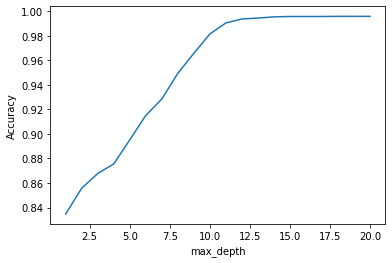

In [39]:
# Calibrando de manera individual max_depth

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1,21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores_depth = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf3 = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores_depth.append(cross_val_score(clf3, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(depth_range, accuracy_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
depth_final = sorted(zip(accuracy_scores_depth, depth_range))[::-1][0][1]
depth_final


Teniendo en cuenta la gráfica cuando max_depth es igual a 10 el valor del accuracy se estabiliza, por lo tanto en la calibración el número óptimo para este parametro será igual a 10.

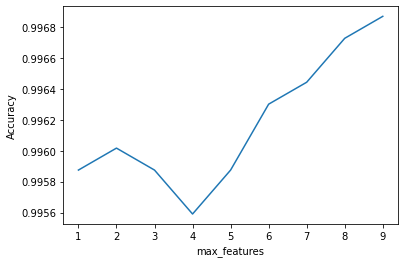

In [27]:
## Calibrando el número maximo de parametros

n_features = X_train.shape[1]

features_range = range(1,n_features+1)

accuracy_scores_feat = []

for feature in features_range:
    clf4 = RandomForestClassifier(max_features=feature, random_state=1)
    accuracy_scores_feat.append(cross_val_score(clf4, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(features_range, accuracy_scores_feat)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
features_final = sorted(zip(accuracy_scores_feat, features_range))[::-1][0][1]


Al igual que el grafico anterior se observa que al tener en cuenta un maximo de 9 parámetros se tiene un accuracy cercano al 99%

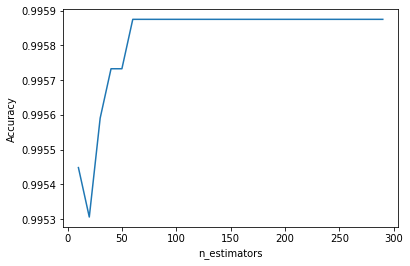

In [28]:
# Calbrando el numero de estimadores
estimator_range = range(10, 300, 10)

accuracy_scores_n = []

for estimator in estimator_range:
    clf5 = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    clf5.fit(X_train, y_train)
    accuracy_scores_n.append(cross_val_score(clf5, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(estimator_range, accuracy_scores_n)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
n_final = sorted(zip(accuracy_scores_n, estimator_range))[::-1][0][1]


En este caso el número de estimadores optimo es igual a 60 ya que a partir de este valor del accuracy se estabiliza

In [41]:
### Realizando el modelo de random forest con los parámetros calibrados
clf6 = RandomForestClassifier()
clf6 = RandomForestClassifier(n_estimators=60, max_features=9, max_depth=10, random_state=1, n_jobs=-1)
clf6.fit(X_train, y_train)
pred6 = clf6.predict(X_test)
des_rfcal_2 = accuracy_score(y_test,pred6)
des_rfcal_2

0.8363163972286374

Los resultados nos muestran que la profundidad máxima del árbol que garantiza el mejor desempeño es de 10. A medida que aumenta la profundidad, después de este valor el desempeño del modelo comienza a caer. 
En relación con el número de variables se observa que 9 es la cantidad que maximiza el desempeño. 

Finalmente, en relación con el número de estimadores, el óptimo lo encontramos en 60. Después de este valor observamos que el accuracy se mantiene constante.

Al entrenar el modelo con los parámetros ya calibrados encontramos que no mejora significativamente el desempeño con relación al modelo del punto 4, pasando de 0.834 a 0.836

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [30]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
des_xg = accuracy_score(y_pred, y_test)
des_xg

0.8666281755196305

El modelo XGBoost con sus parametros por defecto logra un accuracy superior a los anterioires modelos, logrando un accuracy de 0.866, muy similar al obtenido por el modelo de random forest calibrado

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

**Primera forma :** Se calibra simultaneamente los parámetros por medio de RandomizedSearchCV

In [31]:
gamma_range = range(0, 100)
colsample_bytree = np.arange(0.1,1.0,0.01)
learning_rates = np.arange(0.1,1.0,0.01)

random_grid = {'gamma': gamma_range,
               'colsample_bytree': colsample_bytree,
               'learning_rate': learning_rates,
               }

XGBsv=XGBClassifier()
XGBsv_random = RandomizedSearchCV(estimator = XGBsv, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=1, n_jobs = -1)

In [32]:
XGBsv_random.fit(X_train, y_train)
predxg = XGBsv_random.predict(X_test)
des_xg3 = accuracy_score(y_test,predxg)
des_xg3

0.8556581986143187

In [33]:
print(XGBsv_random.best_params_)

{'learning_rate': 0.5699999999999997, 'gamma': 1, 'colsample_bytree': 0.5099999999999998}


Calibrando simultaneamente los tres parámetros se obtiene un accuracy del 85.56% ,donde los parámetros óptimos son:

* learning_rate: 0.57
* gamma: 1
* colsample_bytree: 0.51

**Segunda forma:** Se calibra de manera individual cada uno de los parámetros

4

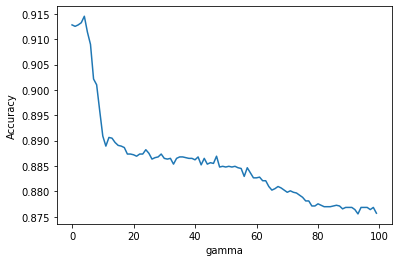

In [34]:
gamma_range = range(0, 100)

# Definición de lista para almacenar la exactitud (accuracy) promedio 
accuracy_scores_gamma = []

# Uso de un 10-fold cross-validation para cada valor 
for dato in gamma_range:
    clf = XGBClassifier(gamma = dato)
    accuracy_scores_gamma.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(gamma_range, accuracy_scores_gamma)
plt.xlabel('gamma')
plt.ylabel('Accuracy')
gamma_final = sorted(zip(accuracy_scores_gamma, gamma_range))[::-1][0][1]
gamma_final

0.9

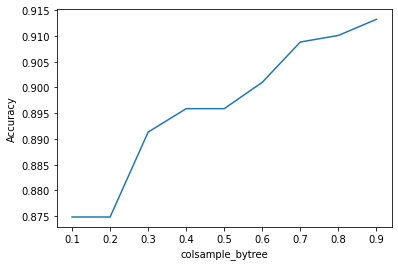

In [35]:
colsample_bytree = np.arange(0.1,1.0,0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio 
accuracy_scores_col = []

# Uso de un 10-fold cross-validation para cada valor
for sample in colsample_bytree:
    clf_2 = XGBClassifier(colsample_bytree = sample, verbosity=0)
    accuracy_scores_col.append(cross_val_score(clf_2, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(colsample_bytree, accuracy_scores_col)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')
col_final = sorted(zip(accuracy_scores_col, colsample_bytree))[::-1][0][1]
col_final

0.9

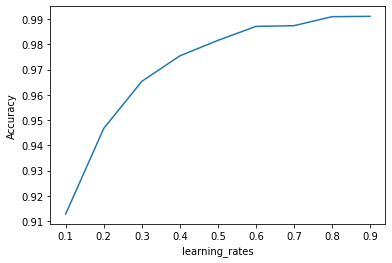

In [36]:
learning_rates = np.arange(0.1,1.0,0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio 
accuracy_scores_learning = []

# Uso de un 10-fold cross-validation para cada valor
for rate in learning_rates:
    clf = XGBClassifier(learning_rate = rate, verbosity=0)
    accuracy_scores_learning.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(learning_rates, accuracy_scores_learning)
plt.xlabel('learning_rates')
plt.ylabel('Accuracy')
lr_final = sorted(zip(accuracy_scores_learning, learning_rates))[::-1][0][1]
lr_final

In [37]:
clf = XGBClassifier(gamma = gamma_final, colsample_bytree = col_final, learning_rate= lr_final)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
des_xg2 = accuracy_score(y_pred, y_test)
des_xg2

0.8495958429561201

Luego de realizar la calibración de los parametros gamma, colsam_bytree y learning rate del modelo XGBoost, se observa un leve disminución del accuracy respecto al modelo con los parametros por defecto, evidencia el gran poder predictivo que posee este modelo con su configuración por defecto.
Adicionalmente, se calibraron los parámetros de manera simultánea y por separado, logrando un mejor resultado con el primer método.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

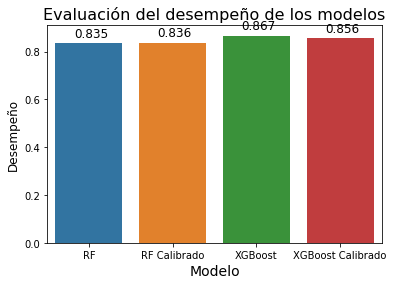

In [38]:
modelos = ['RF','RF Calibrado','XGBoost','XGBoost Calibrado']
accuracys = [des_rf,des_rfcal_2,des_xg,des_xg3]
df = pd.DataFrame(zip(modelos,accuracys), columns=['Modelo', 'Desempeño']) 

plots = sns.barplot(x=modelos, y=accuracys, data=df) 
  
for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.3f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=12, xytext=(2, 10), 
                   textcoords='offset points') 
    
  
plt.xlabel("Modelo", size=14) 
plt.ylabel("Desempeño", size=12)  
plt.title("Evaluación del desempeño de los modelos", size=16) 

plt.show() 

Podemos observar que este tipo de modelos, aunque pierden poder de interpretabilidad, poseen gran poder predictivo, logrando resultados de accuracy entre 0.83 y 0.86. 

En el caso de Random Forest, al calibrar los 3 parámetros selecionados max_depth, n_estimators y n_features no se observa una mejora significativa en el desempeño del modelo. Es probable que el desempeño de este modelo pueda mejorar con la calibración de otros parámetros.

Para el caso de XGBoost se observa que el mejor desempeño se da con los parámetros por defecto y que los parámetros seleccionados para calibrar no mejoraron el desempeño del modelo.

En conclusión, el modelo que mejor desempeño presenta para predecir si el precio de un auto es o no alto es el XGBOost con parámetros por defecto.